In [ ]:
import os
import sys
from datetime import datetime
sys.path.insert(0, "../../..")
sys.path.insert(0, "../../../../acquire")

from HUGS.Processing import search
from HUGS.Client import Process, Search, Retrieve
from Acquire.ObjectStore import datetime_to_string
from Acquire.Client import User, Drive, Service, PAR, Authorisation, StorageCreds

import ipyleaflet as ipl
import ipywidgets as ipw

from pathlib import Path

# Autoreload modules before executing code, useful during development
%load_ext autoreload
%autoreload 2

Search for some EUROCOM data

In [ ]:
from HUGS.Client import Search
from HUGS.Util import get_datapath
import json

In [ ]:
base_url= "https://hugs.acquire-aaai.com/t"
search = Search(service_url=base_url)

In [ ]:
acrg_json = get_datapath(filename="acrg_site_info.json")
with open(acrg_json, "r") as f:
    acrg_sites = json.load(f)

Panel 1 - NOAA with EDGAR

In [ ]:
import matplotlib.pyplot as plt
from cartopy.feature import BORDERS
import cartopy.crs as ccrs
import matplotlib.cm as cm
import xarray as xr
import numpy as np
import ipyleaflet as ipl
from random import uniform

filepath = "/home/gar/Documents/Devel/hugs/user/notebooks/openghg/ch4-anthro_GLOBAL_2012.nc"

# Here try and work  out projection issues

# filepath = "/home/home/gar/Documents/Devel/RSE/hugs/raw_data/ch4-anthro_GLOBAL_2012.nc"

ds = xr.open_dataset(filepath)

domain = "EUROPE"

lon_name = "lon"
lat_name = "lat"

long_values = ds["flux"][lon_name]
lat_values = ds["flux"][lat_name]
zero_values = ds["flux"][:, :, 0]

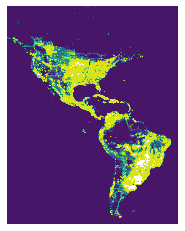

In [ ]:
fig = plt.figure()
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax = fig.add_subplot(111, projection=ccrs.Mercator(), frameon=False)

ax.coastlines(color="0.2")
ax.add_feature(BORDERS, edgecolor="0.5")

ax.set_extent((-140,-30, -60,80),crs=ccrs.Mercator())

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

cmap = cm.get_cmap("viridis")

levels = np.linspace(np.percentile(ds["flux"].values, 5), np.percentile(ds["flux"].values, 97), 10)

ax.contourf(long_values, lat_values, zero_values, cmap=cmap, transform=ccrs.Mercator(), levels=levels)

fig.savefig("emissions_edgar_NAmerica.png", dpi=600, bbox_inches="tight")

In [ ]:
# longitude box of -150,-50b
# latitude box of 0, 60

In [ ]:
# Search NOAA data

In [ ]:
base_url= "https://hugs.acquire-aaai.com/t"
search = Search(service_url=base_url)

search_terms = ["co"]
locations = []

results = search.search(search_terms=search_terms, locations=locations, data_type="NOAA")

Process some of the results to extract the sites etc

In [ ]:
import ipyleaflet as ipl

center = [0, 0]
zoom = 2
noaa_map = ipl.Map(center=center, zoom=zoom)

# Load in the ACRG site data
acrg_json = get_datapath(filename="acrg_site_info.json")
with open(acrg_json, "r") as f:
    acrg_sites = json.load(f)

for res in results:
    site = results[res]["metadata"]["site"]
    
    site = site.upper()
 
    species = results[res]["metadata"]["species"]
    start_date = results[res]["start_date"]
    end_date = results[res]["end_date"]
    
    # Get the latitude and longitude from the ACRG site info
    # As we don't have all the site data stored we skip a few datasets
    try:
        long = acrg_sites[site]["NOAA"]["longitude"]
        lat = acrg_sites[site]["NOAA"]["latitude"]
        long_name = acrg_sites[site]["NOAA"]["long_name"]

        marker = ipl.Marker(location=(lat, long), draggable=False)
        marker.popup = ipw.HTML(value=f"Site: {long_name} ({site})<br>Species: {species.upper()}<br>Daterange: {start_date} -<br>{end_date}")

        noaa_map.add_layer(marker)
    except:
        pass

# Now we overlay the footprint image. In the future this will be dynamically updated from NetCDF
edgar_image_path = "Emissions_Americas.png"

edgar_layer = ipl.ImageOverlay(url=edgar_image_path, bounds=((-60,-140), (55,-30)))
noaa_map.add_layer(edgar_layer)

    
noaa_map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Panel 2 - EUROCOM with footprint

In [ ]:
# filepath = "/home/gar/Documents/Devel/hugs/raw_data/london_footprints/NPL-17magl_UKV_EUROPE_201909.nc"

# ds = xr.open_dataset(filepath)

# domain = "EUROPE"

# fp_name = "fp"
# lon_name = "lon"
# lat_name = "lat"

# long_values = ds[fp_name][lon_name]
# lat_values = ds[fp_name][lat_name]
# zero_values = ds[fp_name][:, :, 0]

# levels = np.linspace(np.percentile(ds[fp_name].values, 5), np.percentile(ds[fp_name].values, 95), 20)


In [ ]:
euro_search_terms = ["co"]
euro_locations = []

eurocom_results = search.search(search_terms=euro_search_terms, locations=euro_locations, data_type="EUROCOM")

KeyError: "Error calling 'search' on 'https://hugs.acquire-aaai.com/t/hugs': 'latest_version'"

In [ ]:
eurocom_results

In [ ]:
center = [54.2361, -4.548]
zoom = 3
eurocom_map = ipl.Map(center=center, zoom=zoom)

for res in eurocom_results:
    site = results[res]["metadata"]["site"]
    
    site = site.upper()
 
    species = results[res]["metadata"]["species"]
    start_date = results[res]["start_date"]
    end_date = results[res]["end_date"]
    
    # Get the latitude and longitude from the ACRG site info
    # As we don't have all the site data stored we skip a few datasets
    try:
        # Some sites may not be associated with EUROCOM in acrg_sites
        network_key = list(acrg_sites[site].keys())[0]
        
        long = acrg_sites[site][network_key]["longitude"]
        lat = acrg_sites[site][network_key]["latitude"]
        long_name = acrg_sites[site]["NOAA"]["long_name"]

        marker = ipl.Marker(location=(lat, long), draggable=False)
        marker.popup = ipw.HTML(value=f"Site: {long_name} ({site})<br>Species: {species.upper()}<br>Daterange: {start_date} -<br>{end_date}")

        eurocom_map.add_layer(marker)
    except:
        pass


Panel 3 - London with Canopy and Footprint

In [ ]:
from ipyleaflet import Map, basemaps, basemap_to_tiles


center = [51.506815, -0.127710]
zoom = 10
map_london = ipl.Map(center=center, zoom=zoom)

dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.Positron)
map_london.add_layer(dark_matter_layer)

lghg_sites = get_datapath("lghg_sites.json")

# Fix legend here
marker_legend = ipw.HTML(value="<img src='marker-icon-blue.png'>   Current site<br><img src='marker-icon-green.png'>   Future site")
marker_control = ipl.WidgetControl(widget=marker_legend, position="topright")

map_london.add_control(marker_control)

with open(lghg_sites, "r") as f:
    lghg_data = json.load(f)
    

for site in lghg_data["current"]:
    curr_site = lghg_data["current"][site]
    
    lat = curr_site["latitude"]
    long = curr_site["longitude"]
    site_name = curr_site["long_name"]
    
    marker = ipl.Marker(location=(lat, long), draggable=False)
    marker.popup = ipw.HTML(value=f"Site: {site_name} ({site})")
    map_london.add_layer(marker)
    
for site in lghg_data["future"]:
    fut_site = lghg_data["future"][site]
    
    lat = fut_site["latitude"]
    long = fut_site["longitude"]
    site_name = fut_site["long_name"]
    
    # Here we want a green icon
    icon = ipl.Icon(icon_url='marker-icon-green.png', icon_size=[25, 40], icon_anchor=[12,15])
    
    marker = ipl.Marker(location=(lat, long), draggable=False, icon=icon)
    marker.popup = ipw.HTML(value=f"Site: {site_name} ({site})")
    map_london.add_layer(marker)
    
    
# Here we can load in just some canopy tiles for Central London
# see https://data.london.gov.uk/dataset/curio-canopy and tile-grid-lookup.zip for the tiles

# with open('/home/home/gar/Documents/Devel/RSE/hugs/canopy_data/gla-hexagon-grid-canopy-cover.geojson', 'r') as f:
#   data = json.load(f)

# geo_json = ipl.GeoJSON(data=data)
# agage_map.add_layer(geo_json)

agage = get_datapath(filename="icos_eurocom_sites.json")

map_london

Map(center=[51.506815, -0.12771], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …